In [11]:
import os
import torch
import torchvision
from torch import nn  
from torchvision import transforms  

#### MNIST data 받아오기 

In [15]:
from torch.utils.data import DataLoader  
from torchvision.datasets import MNIST  

In [25]:
num_epochs = 100 #training data 전체(여기서는 6만개)를 딱 한 번 사용했을 때, 한 epoch이 지나갔다고 말함 
batch_size = 128
#learning_rate = 1e-3

img_transform = transforms.Compose([  #composes several transforms together  
    transforms.ToTensor(), #여기서는 PIL.Image.Image 를 tensor로 바꿔줌 
    transforms.Normalize((0.5,), (0.5,)) #channel 1이므로 각 1개의 element에 해당하는 mean / stdev 
])  


dataset1 = MNIST('./data', transform=img_transform, download  = True) #default 옵션은 train = True 
dataset2 = MNIST('./data', train = False, transform=img_transform, download  = True)
#Dataloader은 Iterator을 반환한다
#배치사이즈만큼 데이터를 로드해줌
dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True) #여기에서 데이터를 꺼낼 때마다 transform적용됨 
dataloader2 = DataLoader(dataset2, batch_size=10000, shuffle=True) #test 데이터 10000개 꺼내는 데 사용할 dataloader  

In [26]:
print(dataset1)
print(dataset2)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None
Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


#### autoencoder model class 생성

In [23]:
class autoencoder(nn.Module):
    def __init__(self, dim): 
        """
        생성자에서 2개의 nn.Sequential 모듈을 생성하고, 멤버변수(self.encoder, self.decoder)로 지정함.  
        """
        super(autoencoder, self).__init__() # 부모클래스(nn.Module)에서 정의된 메소드를 호출, 생성자 선언 
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True), #inplace = True 옵션 -> 또 다른 객체를 반환하지 않고 기존 객체를 수정, 메모리를 아주 조금 save 할 수 있다.    
            nn.Linear(256, 128),
            nn.ReLU(True), nn.Linear(128, 64), nn.ReLU(True), nn.Linear(64, dim)) #latent dimension = 2로 해야 visualization 할 수 있는 듯?
        self.decoder = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(True),  # ReLU를 쓰는 이유는 이게 generation이 아니라 classification이 목적이라서,, 데이터를 많이 버리는 게 좋음 
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256), 
            nn.ReLU(True), nn.Linear(256, 28 * 28), nn.Tanh()) #마지막 layer에 tanh 안해주면 MSEloss 엄청 커짐.. 


    def forward(self, x):  
        """
        순전파 함수에서는 입력 데이터의 Variable을 받아서 출력 데이터의 Variable을
        반환해야 함. Variable 상의 임의의 연산자뿐만 아니라 생성자에서 정의한
        모듈을 사용할 수 있음.
        """
        x_latent = self.encoder(x)
        x_output = self.decoder(x_latent)
        return x_latent, x_output 
    
    def decode(self, x_latent): #decode 함수를 여기서는 따로 지정해주었음 -> 등간격 랜덤 샘플링 후 decoder 통과시키는 거 다시 할라고 
        x_output = self.decoder(x_latent) 
        return x_output 


## 1. latent space dim = 20

In [29]:
model = autoencoder(dim = 20)  
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters()) #lr, weight decay 안써도 됨 -> 쓰면 너무 과다튜닝 하는 것임. 안써도 돼서 Adam이 좋은 것임!

#### Training AE using training data of MNIST

In [30]:
validation_loss = 100 #현재 epoch를 진행한 후 최저의 validation loss 기록을 의미함 
for epoch in range(num_epochs):#num_epochs  
    for data in dataloader1:
        inputs, label = data #inputs.shape = [128,1,28,28], label = [128]
        inputs = inputs.view(inputs.size(0), -1)  #view는 size변경. inputs.size(0) = 128. 즉 inputs의 size를 [128,784]로 바꿔줌 
        #inputs = Variable(inputs) # model에 넣어주려면 Variable로 싸줘야함 -> 이제는 안쓰는 방법^*^ 
        # ===================forward=====================
        _, output1 = model(x = inputs) #autoencoder내에서 forward 진행됨
        loss = criterion(output1,inputs) #MSEloss
        # ===================backward====================
        optimizer.zero_grad()  #무슨기능? / require_grad = True는 gradient 학습시키는 학
        loss.backward()  #loss가지고 backpropagation 시켜주는 과정  
        optimizer.step() #무슨기능?   
    # ===================log========================  
    print('epoch [{}/{}], training loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))
# =============== validation =========================
# test data에 대해서도 한 epoch이 돌 때마다 loss를 보아야 한다  
    for i in range(1):
        for data in dataloader2:
            test_inputs, label = data
            test_inputs = test_inputs.view(test_inputs.size(0), -1)
            _, output2 = model(x = test_inputs)
            loss = criterion(output2, test_inputs) 
    print('epoch [{}/{}], validation loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))  
# 이전 최저 validation_loss와 현재 loss를 비교한다. 현재가 더 작으면 epoch 진행, 아니면 epoch 멈추기    
    if (validation_loss >= loss):
        validation_loss = loss
        torch.save(model.state_dict(), './sim_autoencoder.pth') #모델 저장 
        continue
    else:
        break


epoch [1/100], training loss:0.1258
epoch [1/100], validation loss:0.1249
epoch [2/100], training loss:0.1049
epoch [2/100], validation loss:0.0976
epoch [3/100], training loss:0.0851
epoch [3/100], validation loss:0.0808
epoch [4/100], training loss:0.0728
epoch [4/100], validation loss:0.0709
epoch [5/100], training loss:0.0636
epoch [5/100], validation loss:0.0647
epoch [6/100], training loss:0.0620
epoch [6/100], validation loss:0.0607
epoch [7/100], training loss:0.0591
epoch [7/100], validation loss:0.0565
epoch [8/100], training loss:0.0547
epoch [8/100], validation loss:0.0537
epoch [9/100], training loss:0.0482
epoch [9/100], validation loss:0.0509
epoch [10/100], training loss:0.0467
epoch [10/100], validation loss:0.0487
epoch [11/100], training loss:0.0423
epoch [11/100], validation loss:0.0468
epoch [12/100], training loss:0.0437
epoch [12/100], validation loss:0.0450
epoch [13/100], training loss:0.0439
epoch [13/100], validation loss:0.0445
epoch [14/100], training loss:

In [31]:
# validation_loss 중에 최저
print(validation_loss)  

tensor(0.0376, grad_fn=<MseLossBackward>)


#### Test using MNIST 
- 앞에서 training한 모델에 test input 넣고 forward propagation  
- show output & show latent space  

In [32]:
test_dataset = MNIST('./data', train = False, transform=img_transform, download  = True)  #default 옵션은 train = True 
dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle=True)  

In [33]:
print(test_dataset)  

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


#### test data를 가지고, 앞에서 만들어진 AE에 forward 진행

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [35]:
for i in range(1): #test data에 대해서 한번만 실행 
    for data in dataloader: #batch_size = 10000 
        test_inputs, label = data
        test_inputs = test_inputs.view(test_inputs.size(0), -1)
        #test_inputs = Variable(test_inputs)
        # ========= forward =========
        latent, output = model(x = test_inputs)
        print(latent)
        loss = criterion(output, test_inputs)
        print('test_loss(MSE) :{:.4f}'.format(loss.data))

tensor([[ 6.1116, -1.2074,  4.2404,  ...,  0.2328,  2.7004, -0.0853],
        [ 8.8247, -3.8293,  4.8326,  ..., -0.8040,  3.4985,  1.0023],
        [ 8.9446, -2.7872,  7.4017,  ...,  0.9148,  7.2096,  2.3715],
        ...,
        [ 2.8539, -0.1476,  7.2829,  ..., -1.7748,  8.2358,  3.5703],
        [ 6.9251, -2.0058,  5.8718,  ..., -5.7401,  7.0793,  2.7794],
        [ 9.5148, -4.2269,  5.6451,  ..., -1.1119,  4.0909,  2.8590]],
       grad_fn=<AddmmBackward>)
test_loss(MSE) :0.0376


In [36]:
print(latent.shape)
print(label.shape) #원래 데이터에 대한 label
print(output.shape) #AE를 거친 output 
#print(output[10]) #10번째 데이터 어떻게 생겼는지
print(output[2000].shape)  

torch.Size([10000, 20])
torch.Size([10000])
torch.Size([10000, 784])
torch.Size([784])


In [37]:
#이 두개를 비교해서 matplotlib에 찍어줘야 함
print(test_inputs.shape)  
print(output.shape)  

torch.Size([10000, 784])
torch.Size([10000, 784])


#### Task1. matplotlib 이용해서 실제 데이터와 모델 output 데이터(reconstruction)를 찍어주자!
- test data에 대해서 찍었음  
- 정답(test_inputs)/output/정답(test_inputs)/output -> 번갈아가면서 찍힘  

In [ ]:
temp = np.array(test_inputs[0]) #tensor를 array로 바꾸어줘야 matplotlib로 그릴 수 있음  
temp = np.reshape(temp, (28, 28)) # (784,)를 (28,28)로 만들어줌   

In [38]:
#tensor를 array로 바꾸어줘야 matplotlib로 그릴 수 있음  
# (784,)를 (28,28)로 만들어줌
test_np = np.array(test_inputs)  
output_np = output.detach().numpy()

(10000, 784)

In [83]:
print(test_np.shape)
print(output_np.shape)

(10000, 784)
(10000, 784)


In [40]:
import scipy
from scipy.stats import norm 

In [41]:
#------------이제 test_np랑 output_np를 쓰면 됩니다. ------------
n = 20 
digit_size = 28 #픽셀단위? 
figure = np.zeros((digit_size*n, digit_size*n))  

In [44]:
### 한 column에 같은 이미지들만 들어가 있는 거 고치기  

for i in enumerate(n):
    for j in enumerate(n):  
        if j % 2 == 0: 
            test_tmp = np.array(test_np[int(j/2) + 20*i])  #여기에 20*i를 해줘야함.  
            test_tmp = np.reshape(test_tmp, (28, 28))  #실제 데이터
            figure[(i*digit_size):((i + 1) * digit_size), (j*digit_size): ((j+1)*digit_size)] = test_tmp  
        else:
            out_tmp = np.array(output_np[int(j/2) + 20*i]) 
            out_tmp = np.reshape(out_tmp, (28, 28)) #모델의 output 데이터 
            figure[(i*digit_size):((i + 1) * digit_size), (j*digit_size): ((j+1)*digit_size)] = out_tmp  


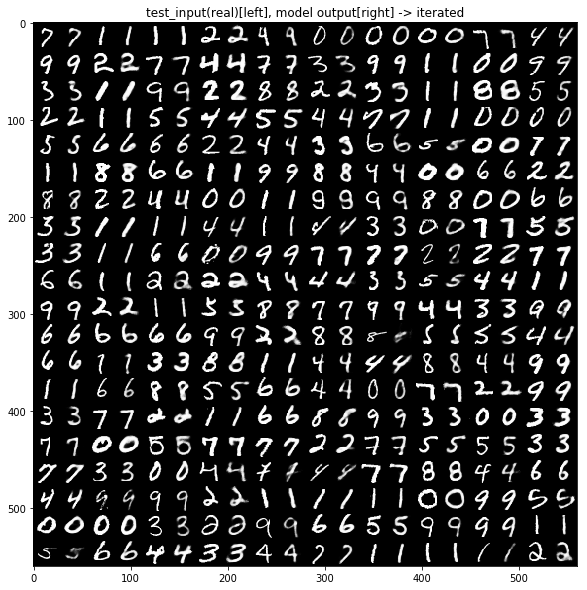

In [45]:
plt.figure(figsize = (10,10))   
plt.title('test_input(real)[left], model output[right] -> iterated')   
plt.imshow(figure, cmap = 'gray')  
plt.show()  

#### Task2. matplotlib 사용해서 latent space를 visualization 하자!
- 여기서는 latent space를 2-dimension으로 해서 해야함! 
- test data 를 이용함 

#### a. PCA를 이용하여 2개의 dimension을 선택 (위 latent dimension = 20 을 이용)  하여 그 2차원 좌표 상에 데이터를 표현함  

In [46]:
from sklearn.decomposition import PCA  

In [47]:
pca = PCA(n_components = 2)  
latent_np = latent.detach().numpy()
pca_output = pca.fit_transform(latent_np)   

In [48]:
type(pca_output)  

numpy.ndarray

(10000, 2)
(10000, 784)


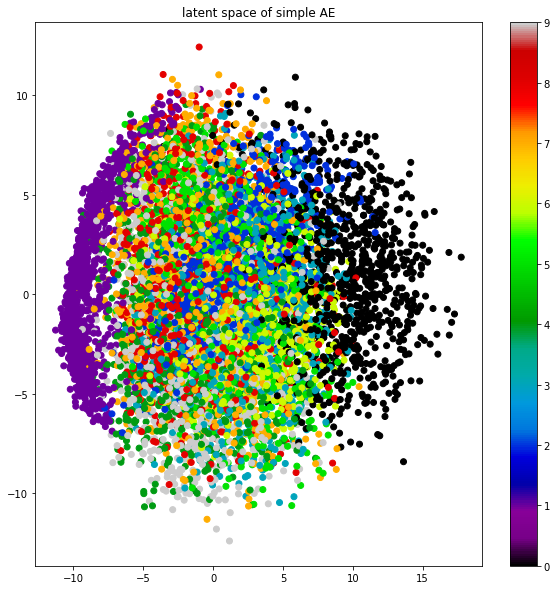

In [49]:
# test 데이터를 forward propagation 했을 때 latent space를 visualization 하자
output_np = output.detach().numpy()   
print(pca_output.shape) 
print(output_np.shape) 
plt.figure(figsize = (10,10))   
plt.scatter(pca_output[:,0], pca_output[:,1], c = label, cmap = 'nipy_spectral') # latent space의 feature 수를 2로 줄여야 하는지 
plt.clim(0,9) 
plt.colorbar()  
plt.title('latent space of simple AE')  
plt.show() 

## 2. latent space dim = 2

In [53]:
num_epochs = 100 #training data 전체(여기서는 6만개)를 딱 한 번 사용했을 때, 한 epoch이 지나갔다고 말함 

In [70]:
model2 = autoencoder(dim = 2)  
criterion2 = nn.MSELoss()  
optimizer2 = torch.optim.Adam(model2.parameters())   

#### training 하기 

In [71]:
validation_loss = 100 
for epoch in range(num_epochs):#num_epochs
    for data in dataloader1:
        inputs, label = data
        inputs = inputs.view(inputs.size(0),-1)
        #inputs = Variable(inputs) -> 안씀 
        #==== forward
        latent, output1 = model2(x = inputs)
        #==== backward
        loss = criterion2(output1, inputs)  
        optimizer2.zero_grad()
        loss.backward() 
        optimizer2.step() 
    print("epoch [{}/{}], train loss:{:.4f}".format(epoch+1, num_epochs, loss.data))
    # =============== validation =========================
# test data에 대해서도 한 epoch이 돌 때마다 loss를 보아야 한다  
    for i in range(1):
        for data in dataloader2:
            test_inputs, label = data
            test_inputs = test_inputs.view(test_inputs.size(0), -1)
            _, output2 = model2(x = test_inputs)
            loss = criterion(output2, test_inputs) 
    print('epoch [{}/{}], validation loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))  
# 이전 최저 validation_loss와 현재 loss를 비교한다. 현재가 더 작으면 epoch 진행, 아니면 epoch 멈추기    
    if (validation_loss >= loss):
        validation_loss = loss
        torch.save(model2.state_dict(), './sim_autoencoder2.pth') #모델 저장 
        continue
    else:
        break



epoch [1/100], train loss:0.1843
epoch [1/100], validation loss:0.1870
epoch [2/100], train loss:0.1670
epoch [2/100], validation loss:0.1711
epoch [3/100], train loss:0.1695
epoch [3/100], validation loss:0.1647
epoch [4/100], train loss:0.1623
epoch [4/100], validation loss:0.1604
epoch [5/100], train loss:0.1568
epoch [5/100], validation loss:0.1583
epoch [6/100], train loss:0.1605
epoch [6/100], validation loss:0.1558
epoch [7/100], train loss:0.1509
epoch [7/100], validation loss:0.1533
epoch [8/100], train loss:0.1377
epoch [8/100], validation loss:0.1521
epoch [9/100], train loss:0.1462
epoch [9/100], validation loss:0.1521


In [72]:
print(output1.shape) #마지막 배치에서 데이터 개수가 이렇게 되어서 그렇다  

torch.Size([96, 784])


#### test 하기

In [73]:
test_dataset = MNIST('./data', train = False, transform = img_transform, download = True)
dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle = True)   

In [74]:
for i in range(1):  
    for data in dataloader:  
        test_inputs, label = data  
        test_inputs = test_inputs.view(test_inputs.size(0), -1)  
        #test_inputs = Variable(test_inputs) 
        latent, output = model2(x = test_inputs)  
        loss = criterion2(output, test_inputs)
        print('test_loss(MSE): {:.4f}'.format(loss.data))  #위에 최저 validation loss와 같아야 함 (마지막 바로 전꺼) 

test_loss(MSE): 0.1521


In [75]:
test_inputs.shape

torch.Size([10000, 784])

#### latent space 

(10000, 2)
(10000, 784)


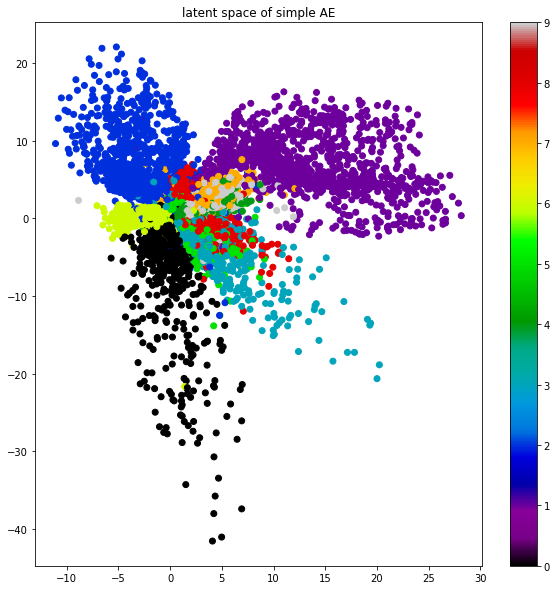

In [76]:
# test 데이터를 forward propagation 했을 때 latent space를 visualization 하자
latent_np = latent.detach().numpy()  
output_np = output.detach().numpy()  
print(latent_np.shape)
print(output_np.shape)
plt.figure(figsize = (10,10))  
plt.scatter(latent_np[:,0], latent_np[:,1], c = label, cmap = 'nipy_spectral') # latent space의 feature 수를 2로 줄여야 하는지 
plt.clim(0,9) 
plt.colorbar() 
plt.title('latent space of simple AE')  
plt.show() 

####  위 그림에서 등간격으로 sampling해서(uniform하게?) -> decoder 통과시켜서, latent space 상에서 한 것과 비교하기!! 

- uniform 하게 sampling 해서 통과시킨 것과, 위에서 latent space 상에 표현해 준 것이 비슷하게 나와야 함  
- 한 이미지당 dimension = 2인 것을 랜덤 샘플링 해서, 그것을 decoder단에 통과시킴   
- 한 변에 총 20개의 이미지를 표현해 줄 예정  

In [77]:
from torch.distributions import uniform  

In [ ]:
#range를 위에 그림에 맞게 해서 다시 sampling 하기 ! 지금 0~1사이에서만 sampling되어서 밑에 그림이 이상하게 나온 것  

In [78]:
n = 20
digit_size = 28
z_grid = torch.empty(n*n, 2) 
z_grid.shape

x_len = latent[:,0].max() - latent[:,0].min()  
x_section_len = float(x_len / n) #이 구간 길이에서 20개 sampling   
y_len = latent[:,1].max() - latent[:,1].min() 
y_section_len = float(y_len / n)  

z_grid = torch.empty(n*n,2) 
#등간격 샘플링
for i in range(n): 
    for j in range(n):  
        z_grid[(i*n + j), 0] = torch.empty(1,).uniform_(float(latent[:,0].min()) + i*x_section_len, float(latent[:,0].min()) + (i+1)*x_section_len) #i행의 x값
        z_grid[(i*n + j), 1] = torch.empty(1,).uniform_(float(latent[:,1].max()) - j*y_section_len, float(latent[:,1].max()) - (j+1)*y_section_len) #j행의 y값   

In [79]:
print(latent[:,0].max())  
print(latent[:,0].min())
print(latent[:,1].max())
print(latent[:,1].min())
print()
print(x_section_len)
print(y_section_len)
print()
print(z_grid[:,0].max())
print(z_grid[:,0].min())
print(z_grid[:,1].max())
print(z_grid[:,1].min()) 
print()
print(z_grid[0]) 

tensor(28.1540, grad_fn=<MaxBackward1>)
tensor(-11.0778, grad_fn=<MinBackward1>)
tensor(22.0546, grad_fn=<MaxBackward1>)
tensor(-41.5399, grad_fn=<MinBackward1>)

1.9615886211395264
3.1797232627868652

tensor(28.1137)
tensor(-10.9050)
tensor(22.0131)
tensor(-41.3600)

tensor([-10.1651,  18.9120])


In [80]:
#샘플링 한 것을 decode단에 통과시키기  
grid_out = model2.decode(z_grid)  
grid_out.shape  
grid_out = grid_out.reshape(n, n, digit_size, digit_size)   
grid_out.shape  

torch.Size([20, 20, 28, 28])

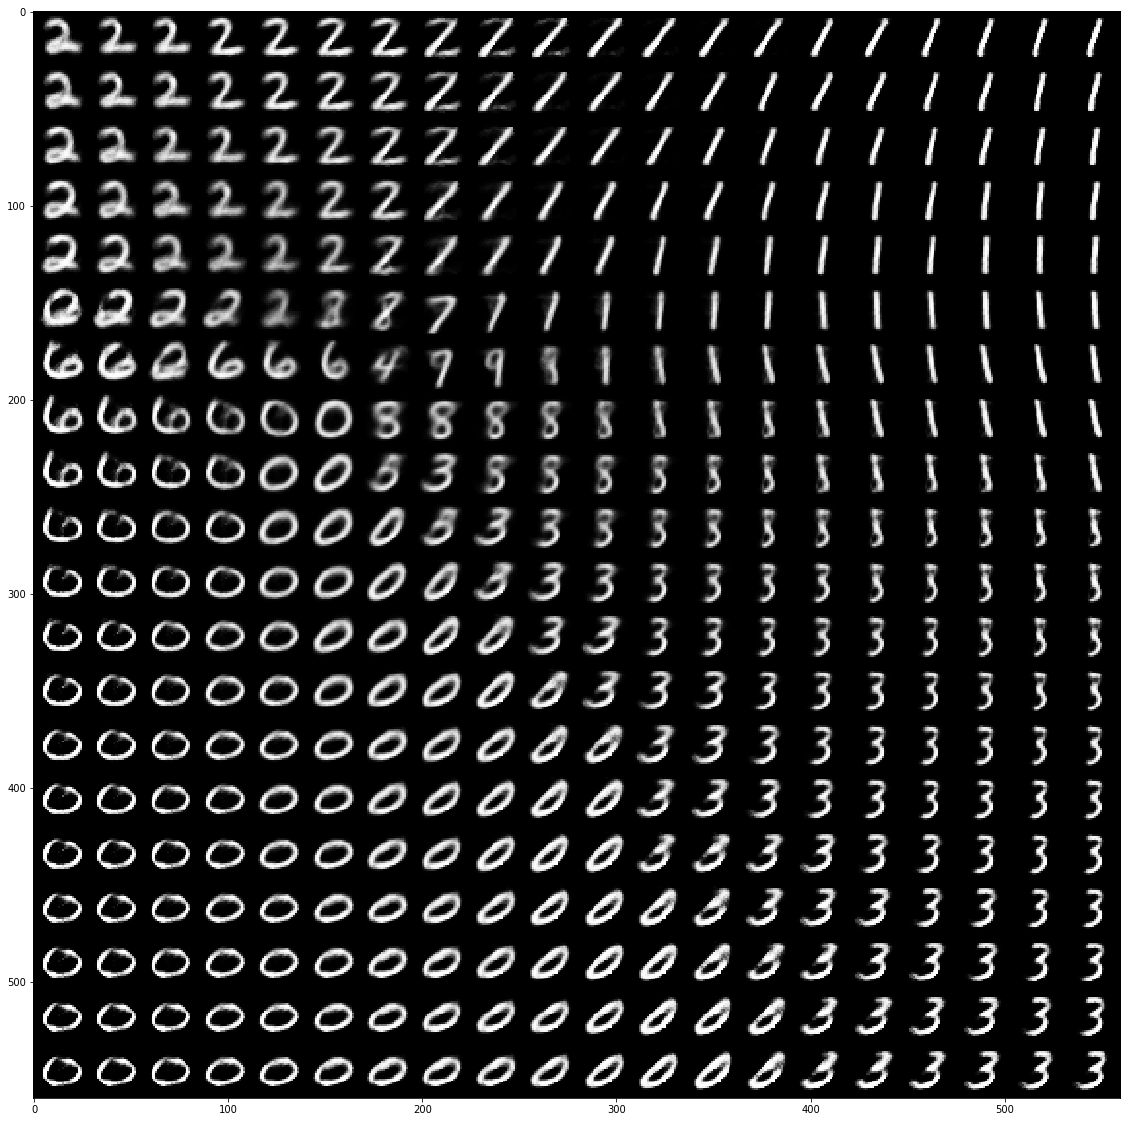

In [81]:
## for문으로 다시 짜기  
figure = np.zeros((digit_size*n, digit_size*n))

for i in range(n):  
    for j in range(n):  
        temp = grid_out[i,j]  
        temp = temp.detach().numpy()  
        figure[j*digit_size:(j+1)*(digit_size), i*digit_size:(i+1)*digit_size] = temp    

plt.figure(figsize=(20,20))     
plt.imshow(figure, cmap='gray')    
plt.show()     